# *Scientific Progress Goes Boink!* - Training a Generative Adversarial Network on a Cartoon Dataset

by Brennan McFarland

Let's transmogify some noise

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from keras.layers import Lambda
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
import matplotlib.pyplot as plt
import argparse
import os
import math
import matplotlib.pyplot as plt

import sys
import csv
import re
import random
from skimage import io
from skimage.transform import downscale_local_mean
import numpy as np
from keras import backend as K
from keras.engine.topology import Layer
from keras.utils import Sequence
from keras.models import Model
from keras.layers import Multiply, Input, Conv2D, Conv3D, Conv2DTranspose, Conv3DTranspose, MaxPooling2D, MaxPooling3D, UpSampling2D, Dense, Flatten, Activation, Reshape, BatchNormalization, LeakyReLU, PReLU
from keras.optimizers import RMSprop, Adam
from keras.callbacks import LambdaCallback
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras import initializers

Using TensorFlow backend.


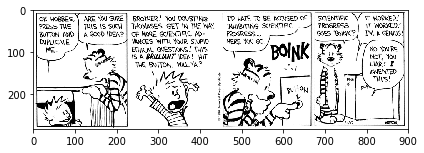

In [2]:
img = io.imread('intro_img.png', as_gray=True)
io.imshow(img, aspect='equal')

In [3]:
data_root = 'E:/ML/keras/data/cartoons/'
output_root = 'E:/ML/keras/cartoons/'
random.seed()

In [4]:
# TODO: these two helper functions were copied directly from the example,
# look at them closer when you get the chance
def load_metadata():
    metadata = []
    with open(data_root + 'metadata.csv', 'r', newline='') as metadata_file:
        reader = csv.reader(metadata_file, quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for row in reader:
            metadatum = row[:2] + [int(n) for n in re.findall(r'\d+', row[2])]
            metadata.append(metadatum)
    return metadata

In [5]:
metadata = load_metadata()
random.shuffle(metadata)
metadata_train = metadata[len(metadata)//10:]
metadata_test = metadata[:len(metadata_train)]
num_data = len(metadata)

classes = set([datum[0] for datum in metadata])
# build a dictionary mapping between name strings and ids
class_to_id = dict((n, i) for i, n in enumerate(classes))
id_to_class = dict((i, n) for i, n in enumerate(classes))
num_classes = len(classes)

In [6]:
# TODO: may want to try using the ImageDataGenerator class, but the problem is that it would
# have to be able to work with one batch at a time loaded with its respective metadata from
# files
# could write a quick script to rename all the images with ids and make that the first value in
# each csv row, then use flow_from_directory and use that id to get the metadata, but I'm too
# lazy to do that right now
class DataProvider(Sequence):

    metadata = None
    batch_size = 1 # TODO: obviously we'll need to find the optimal batch size
    
    def __init__(self, metadata):
        self.metadata = metadata
    
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        x, y = self.get_batch(self.batch_size, self.metadata)
        if x is None or y is None:
            raise ValueError("input x or y is none")
        return x, y

    # TODO: optimize the batches to use np arrays from the getgo?
    def get_batch(self, batch_size, metadata):
        img_x, img_y = 150, 450
        batch_x = np.zeros((batch_size, img_x, img_y), dtype=float)
        batch_y = np.zeros((batch_size, img_x, img_y), dtype=float)
        for i in range(batch_size):
            datum_indices = np.random.randint(0, len(metadata), size=2)
            img_scaled = None
            j = 0
            while img_scaled is None:
                img_scaled = self.get_image(metadata, (datum_indices[0] + j) % len(metadata))
                metadatum = metadata[datum_indices[0]]
                j += 1
                #datum_indices[0] = (datum_indices[0] + 1) % len(metadata)
            
            # put it in a tensor after downscaling it and padding it
            img_downscaled = downscale_local_mean(img_scaled, (2, 2))
            # normalize channel values
            # TODO: was maximum, but maybe manuallly setting to 1 will make ti work better for now
            batch_x[i] = np.pad(img_downscaled, ((0,0), (0, img_y-img_downscaled.shape[1])), 'constant', constant_values=1)

            img_scaled = None
            j = 0
            while img_scaled is None:
                img_scaled = self.get_image(metadata, (datum_indices[1] + j) % len(metadata))
                metadatum = metadata[datum_indices[1]]
                j += 1
                #datum_indices[1] = (datum_indices[1] + 1) % len(metadata)
            
            # put it in a tensor after downscaling it and padding it
            img_downscaled = downscale_local_mean(img_scaled, (2, 2))
            # normalize channel values
            batch_y[i] = np.pad(img_downscaled, ((0,0), (0, img_y-img_downscaled.shape[1])), 'maximum')
            batch_x[i] /= 255.0
            batch_y[i] /= 255.0
            batch_x = self.convert_to_sample(batch_y)
            #batch_y[i][class_to_id[metadatum[0]]] = 1
        #return np.expand_dims(batch_x, axis=3), batch_y
        return np.expand_dims(batch_x, axis=3), np.expand_dims(batch_y, axis=3)
        # TODO: need to have it differentiate different strip sizes, ie sunday vs weekday strips

    # if outside the tolerance range, return None (it's not a valid datum)
    # if to large, crop from both sides to fit
    # if to small, pad with maximum value (white) to fit
    def scale_to_target(self, image, initial_y, target_y, shrink_tolerance, grow_tolerance):
        if(target_y-initial_y > grow_tolerance or initial_y-target_y > shrink_tolerance):
            #print('image oustide acceptable dimensions, ', image.shape)
            return None
        elif(initial_y > target_y):
            #print('shrinking to fit target dimensions')
            return image[:target_y]
        else: # initial_y <= target_y
            #print('growing to fit target dimensions')
            padding = (target_y-initial_y)//2
            return np.pad(image, ((padding, target_y - initial_y - padding),(0,0)), 'maximum')

    def get_image(self, metadata, datum_index):
        img_x, img_y = 150, 450
        metadatum = metadata[datum_index]
        # TODO: we'll need to make it color for some strips later
        img_raw = io.imread(data_root + 'images/' + metadatum[0] + metadatum[1] + '.png', as_gray=True)
        # print('raw image: ', img_raw.shape)
        img_scaled = self.scale_to_target(img_raw, metadatum[2], img_x*2, 5, 120)
        return img_scaled


    # 1 is white, 0 is black, remember
    def convert_to_sample(self, img):
        p_black = .2
        sample = np.random.choice((0.0, 1.0), size=img.shape, p=(p_black, 1.0-p_black)) # p is probability of each option
        # element-wise max
        return np.maximum(sample, img)

In [7]:
class PixelCNN(Conv2D):
    ''' Start w/ simple PixelCNN and then make it better once it works '''

    def __init__(self, filters, *args, mask_current=True, n_channels=1, mono=False, **kwargs):
        self.mask_current = mask_current
        self.mask = None
        self.num_filters = filters
        self.num_channels = n_channels
        super(PixelCNN, self).__init__(filters, *args, **kwargs)


    # defining the layer weights and mask
    def build(self, input_shape):
        print(self.kernel_size)
        # (filter width, filter height, input dimensions/channels/filters, output filters)
        kernel_shape = self.kernel_size + (input_shape[-1], self.num_filters) # (self.num_channels, self.num_channels)
        self.kernel = self.add_weight(name='kernel',
                                      shape=kernel_shape,
                                      initializer=initializers.random_uniform(minval=-1.0, maxval=1.0),
                                      trainable=True)
        self.mask = np.zeros(self.kernel.shape) # W_shape must be inherit from Conv2D or layer
        assert self.mask.shape[0] == self.mask.shape[1] # assert that mask height = width
        filter_size = self.mask.shape[0]
        filter_center = filter_size/2

        # unmask everything before the center
        self.mask[:math.floor(filter_center)] = 1 # unmask rows above
        self.mask[:math.ceil(filter_center), :math.floor(filter_center)] = 1 # unmask cols to the left in same row

        if not self.mask_current:
            self.mask[math.ceil(filter_center), math.ceil(filter_center)] = 1

        self.mask = K.variable(self.mask)

        self.bias = None
        self.built = True

    # the logic the layer performs when called in training/evaluation
    def call(self, x, mask=None):
        ''' calculate gated activation maps given input maps '''
        # TODO: I did this just to make everything masked white, but can we do this when
        # precalculating the mask instead?
        output = K.conv2d(x, self.kernel * self.mask + (-self.mask + 1),
                          strides=self.strides,
                          padding=self.padding,
                          data_format=self.data_format)
        if self.bias:
            output += K.reshape(self.get_weights()[1], (1, 1, 1, self.filters))
        output = self.activation(output)
        return output

    def get_config(self):
        return dict(list(super().get_config().items()) + list({'mask': self.mask_current}.items()))
    
    # data shape transformation logic required by keras API
    def compute_output_shape(self, input_shape):
        return super(PixelCNN, self).compute_output_shape(input_shape)

In [37]:
class GANModel():
    
    def __init__(self, generator, discriminator, callbacks):
        self.generator = generator
        self.discriminator = discriminator
        self.gan_inputs = Input(shape=(150, 450, 1))
        self.gan_images = self.generator(self.gan_inputs)
        self.gan_output = self.discriminator(self.gan_images)
        self.gan = Model(inputs=self.gan_inputs, outputs=[self.gan_images, self.gan_output])
        self.callbacks = callbacks
    
    def compile(self):
        self.g_optimizer = Adam(lr=.0001)
        self.d_optimizer = Adam(lr=.0001)
        self.gan_optimizer = Adam(lr=.0001)
        self.discriminator.trainable = True
        self.discriminator.compile(optimizer=self.d_optimizer, loss='mse')
        self.discriminator.trainable = False
        self.gan_loss = ['binary_crossentropy', 'mse']
        self.gan_loss_weights = [100, 1] # TODO: play with
        self.gan.compile(optimizer=self.gan_optimizer, loss=self.gan_loss, loss_weights = self.gan_loss_weights)
        self.discriminator.trainable = True
    
    def train(self, train_data, test_data, epochs):
        steps_per_epoch = num_data//train_data.batch_size
        discriminator_updates = 1
        
        self.gan.summary()

        # manually set callbacks since we're doing a custom fit
        for callback in self.callbacks:
            callback.set_model(self.gan)
        
        # initial call to the callbacks before training
        for callback in self.callbacks:
            callback.on_epoch_end(0, {})
        
        for epoch in range(epochs):
            for step in range(steps_per_epoch):
                current_batch = train_data.__getitem__(0)
                # generate "fake" images
                generator_inputs = current_batch[0]
                generated_images = self.generator.predict(generator_inputs, batch_size=1)
                # train discriminator on "real" images from the dataset and "fake" ones that were generated
                true_inputs, true_labels = current_batch[1], np.ones(len(current_batch[1]))
                fake_inputs, fake_labels = generated_images, np.zeros(len(generated_images))
                for _ in range(discriminator_updates):
                    d_loss_real = self.discriminator.train_on_batch(true_inputs, true_labels)
                    d_loss_fake = self.discriminator.train_on_batch(fake_inputs, fake_labels)
                    d_loss = .5 * np.sum((d_loss_real, d_loss_fake))
                # halt training on the discriminator
                self.discriminator.trainable = False
                # train generator to try to fool the discriminator
                g_loss = self.gan.train_on_batch(generator_inputs, [true_inputs, true_labels])
                # and allow training on the discriminator to continue
                self.discriminator.trainable = True
                print('step ', step, '/', steps_per_epoch, 'd_loss: ', d_loss, 'g_loss: ', g_loss)
            # manually call callbacks since we're doing a custom fit
            logs = {'loss': g_loss}
            for callback in self.callbacks:
                callback.on_epoch_end(epoch, logs)
        # manually terminate callbacks since we're doing a custom fit
        for callback in self.callbacks:
            callback.on_train_end('_')

In [38]:
class Evaluator:

    def __init__(self, test_data):
        self.test_data = test_data
    
    def report_epoch_progress(self, epoch, logs):
        print('epoch progress report:')
        for i in range(num_classes):
            example = self.test_data.__getitem__(3)
            
            print('INPUT')
            latent = example[0]
            input = np.squeeze(latent, axis=(0,3))
            input *= 255.0
            input = input.astype(int)
            filename3 = output_root + 'epoch-output/latest-' + str(i) + '-input.png'
            #io.imsave(filename3, latent)
            io.imshow(input, cmap='gray')
            io.show()
            
            print('PREDICTED')
            img = generator.predict(latent)
            print(img.shape)
            img = np.squeeze(img, axis=(0,3))
            img *= 255.0
            img = img.astype(int)
            print('image shape:', img.shape)
            filename = output_root + 'epoch-output/latest-' + str(i) + '-predicted.png'
            #io.imsave(filename, img)
            io.imshow(img, cmap='gray')
            io.show()

            print('TARGET')
            actual = example[1]
            actual = np.squeeze(actual, axis=(0,3))
            actual *= 255.0
            actual = actual.astype(int)
            filename2 = output_root + 'epoch-output/latest-' + str(i) + '-actual.png'
            #io.imsave(filename2, actual)
            io.imshow(actual, cmap='gray')
            io.show()

            


In [39]:
def test_gan(generator, discriminator):
    data_train = DataProvider(metadata_train)
    data_test = DataProvider(metadata_test)
    evaluator = Evaluator(data_test)
    progress_callback = LambdaCallback(on_epoch_end=evaluator.report_epoch_progress)
    model = GANModel(generator, discriminator, callbacks=[progress_callback])
    model.compile()
    model.train(data_train, data_test, 3)

In [40]:
d_input = Input(shape=(150, 450, 1), name='discriminator_input')
layer = Conv2D(filters=32, kernel_size=(4, 4), strides=4, padding='same')(d_input)
layer = BatchNormalization()(layer)
layer = LeakyReLU(.25)(layer)
layer = Conv2D(filters=32, kernel_size=(4, 4), strides=4, padding='same')(layer)
layer = LeakyReLU(.25)(layer)
layer = Conv2D(filters=32, kernel_size=(4, 4), strides=4, padding='same')(layer)
layer = LeakyReLU(.25)(layer)
layer = Flatten()(layer)
layer = Dense(128)(layer)
layer = Activation('sigmoid')(layer)
d_output = Dense(1)(layer)

discriminator = Model(d_input, d_output, name='discriminator')

### Base Generator

In [41]:
input = Input(shape=(150, 450, 1), name='z_sampling')
layer = PixelCNN(8, 7, strides=1, mask_current=True, padding='same')(input)
layer = PReLU()(layer)
layer = PixelCNN(8, 7, strides=1, mask_current=True, padding='same')(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(8, 7, strides=1, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(8, 7, strides=1, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(8, 7, strides=1, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(1, 7, strides=1, padding='same')(layer)
output = Activation('sigmoid')(layer)

generator = Model(input, output, name='generator')

(7, 7)
(7, 7)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 150, 450, 1)       0         
_________________________________________________________________
generator (Model)            (None, 150, 450, 1)       2713449   
_________________________________________________________________
discriminator (Model)        (None, 1)                 132065    
Total params: 2,713,513
Trainable params: 2,713,401
Non-trainable params: 112
_________________________________________________________________
epoch progress report:
INPUT


c:\users\his eminence\appdata\local\programs\python\python36\lib\site-packages\keras\engine\training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
c:\users\his eminence\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


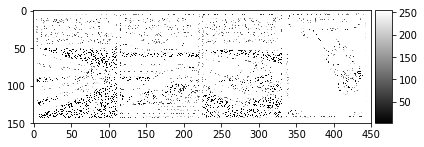

PREDICTED
(1, 150, 450, 1)
image shape: (150, 450)


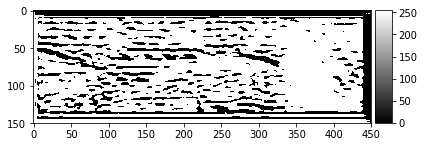

TARGET


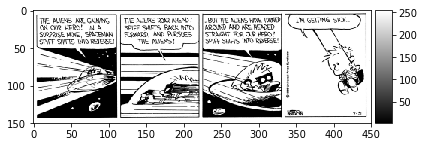

INPUT


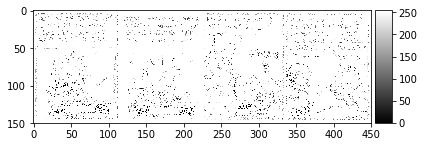

PREDICTED
(1, 150, 450, 1)
image shape: (150, 450)


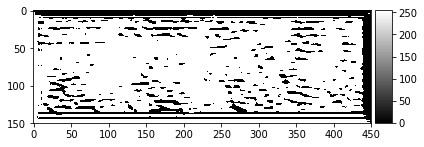

TARGET


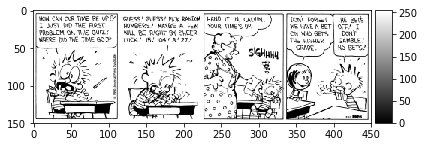

INPUT


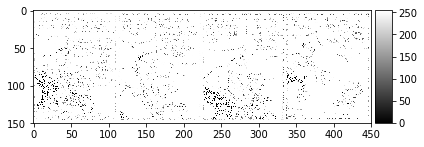

PREDICTED
(1, 150, 450, 1)
image shape: (150, 450)


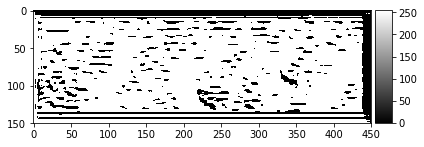

TARGET


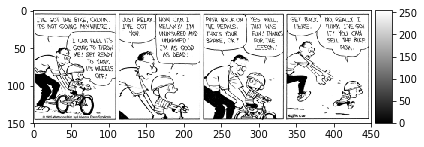

step  0 / 7367 d_loss:  0.28619077801704407 g_loss:  [86.978264, 0.8687465, 0.10361647]
step  1 / 7367 d_loss:  0.28118830919265747 g_loss:  [85.28766, 0.8517436, 0.113301046]
step  2 / 7367 d_loss:  0.27264317870140076 g_loss:  [83.01507, 0.828592, 0.15586564]
step  3 / 7367 d_loss:  0.2187989503145218 g_loss:  [81.90709, 0.81739074, 0.16801488]
step  4 / 7367 d_loss:  0.3076689839363098 g_loss:  [79.421, 0.79225785, 0.19521116]
step  5 / 7367 d_loss:  0.23678547143936157 g_loss:  [76.20716, 0.75991404, 0.21575683]
step  6 / 7367 d_loss:  0.22146686911582947 g_loss:  [77.52761, 0.7734218, 0.18542549]
step  7 / 7367 d_loss:  0.11703088879585266 g_loss:  [76.32422, 0.76094633, 0.22958033]
step  8 / 7367 d_loss:  0.1217947006225586 g_loss:  [77.287346, 0.769751, 0.3122451]
step  9 / 7367 d_loss:  0.09927543997764587 g_loss:  [75.82899, 0.75512594, 0.3163923]
step  10 / 7367 d_loss:  0.10003653168678284 g_loss:  [75.27441, 0.74946827, 0.327586]
step  11 / 7367 d_loss:  0.14858421683311462

step  93 / 7367 d_loss:  0.3553972542285919 g_loss:  [42.9225, 0.42448407, 0.474096]
step  94 / 7367 d_loss:  0.21757124364376068 g_loss:  [44.481945, 0.4399151, 0.4904371]
step  95 / 7367 d_loss:  0.13167330622673035 g_loss:  [46.017925, 0.45473668, 0.5442588]
step  96 / 7367 d_loss:  0.12645798921585083 g_loss:  [42.957317, 0.4270895, 0.24836671]
step  97 / 7367 d_loss:  0.1790848672389984 g_loss:  [41.476017, 0.4110254, 0.37347835]
step  98 / 7367 d_loss:  0.14237286150455475 g_loss:  [46.20926, 0.45843604, 0.365654]
step  99 / 7367 d_loss:  0.10944675654172897 g_loss:  [39.79627, 0.39399093, 0.39717627]
step  100 / 7367 d_loss:  0.1312583088874817 g_loss:  [42.008133, 0.41777718, 0.23041506]
step  101 / 7367 d_loss:  0.07064838707447052 g_loss:  [41.23035, 0.40988648, 0.24170172]
step  102 / 7367 d_loss:  0.14164027571678162 g_loss:  [46.03091, 0.4573166, 0.29925117]
step  103 / 7367 d_loss:  0.21047845482826233 g_loss:  [44.57579, 0.44014442, 0.56134814]
step  104 / 7367 d_loss:  

step  186 / 7367 d_loss:  0.10479123890399933 g_loss:  [35.1181, 0.34812206, 0.3058912]
step  187 / 7367 d_loss:  0.04519063979387283 g_loss:  [33.506153, 0.33253297, 0.25285757]
step  188 / 7367 d_loss:  0.06187183037400246 g_loss:  [41.977226, 0.41619712, 0.35751516]
step  189 / 7367 d_loss:  0.17504706978797913 g_loss:  [33.92128, 0.33587644, 0.33363637]
step  190 / 7367 d_loss:  0.06125587224960327 g_loss:  [30.227676, 0.29801348, 0.42632928]
step  191 / 7367 d_loss:  0.0008097015088424087 g_loss:  [32.572605, 0.3217258, 0.40002963]
step  192 / 7367 d_loss:  0.003616212634369731 g_loss:  [34.13299, 0.3387151, 0.2614829]
step  193 / 7367 d_loss:  0.05834730342030525 g_loss:  [34.315052, 0.340075, 0.30755314]
step  194 / 7367 d_loss:  0.11733122915029526 g_loss:  [28.006845, 0.27650297, 0.3565475]
step  195 / 7367 d_loss:  0.0897308886051178 g_loss:  [32.147804, 0.31850335, 0.29747054]
step  196 / 7367 d_loss:  0.13839203119277954 g_loss:  [37.779575, 0.3753315, 0.24642734]
step  197

KeyboardInterrupt: 

In [42]:
test_gan(generator, discriminator)

### Conv2DTranspose only generator

In [ ]:
input = Input(shape=(150, 450, 1), name='z_sampling')
layer = Conv2DTranspose(8, 7, strides=1, padding='same')(input)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(8, 7, strides=1, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(8, 7, strides=1, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(8, 7, strides=1, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(8, 7, strides=1, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(1, 7, strides=1, padding='same')(layer)
output = Activation('sigmoid')(layer)

g_transposed_conv = Model(input, output, name='transposed_convolution_generator')

In [ ]:
test_gan(g_transposed_conv, discriminator)

In [ ]:
input = Input(shape=(150, 450, 1), name='z_sampling')
layer = PixelCNN(8, 7, strides=1, mask_current=True, padding='same')(input)
layer = PReLU()(layer)
layer = PixelCNN(8, 7, strides=1, mask_current=True, padding='same')(layer)
layer = PReLU()(layer)
layer = PixelCNN(8, 7, strides=1, mask_current=True, padding='same')(layer)
layer = PReLU()(layer)
layer = PixelCNN(8, 7, strides=1, mask_current=True, padding='same')(layer)
layer = PReLU()(layer)
layer = PixelCNN(8, 7, strides=1, mask_current=True, padding='same')(layer)
layer = PReLU()(layer)
layer = PixelCNN(8, 7, strides=1, mask_current=True, padding='same')(layer)
output = Activation('sigmoid')(layer)

g_pixelcnn = Model(input, output, name='PixelCNN_generator')

In [ ]:
test_gan(g_pixelcnn, discriminator)